# Using XT3D for More Accurate Flows on an Unstructured Grid

In this notebook we'll demonstrate the improved accuracy XT3D can provide in flow simulations on unstructured grids. The DISV grid in this example is a rectangular grid with an area of quadtree refinement in the middle. The connections between cells of different sizes violate the CVFD requirements, rendering the standard, conductance-based flow formulation less accurate.

This notebook is based on the MODFLOW 6 "Nested Grid" ([ex-gwf-u1disv](https://modflow6-examples.readthedocs.io/en/latest/_examples/ex-gwf-u1disv.html)) example problem, which corresponds to the first example described in the MODFLOW-USG documentation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.cvfdutil
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

Set file paths for this example.

In [2]:
path_to_mf6 = "mf6"

### Define parameters

Define model units.

In [3]:
# Model units
length_units = "meters"
time_units = "days"

Set model parameters and other settings.

In [5]:
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type is set to confined
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$), isotropic

### TDIS data
Simulation has 1 steady stress period (1 day)
Each transient stress period has 120 2-hour time steps.

In [6]:
nper = 1  # Number of periods
perlen = [1.0] # period length
nstp = [1] # nr. of timesteps
tsmult = [1.0, 1.0, 1.0] # timestep multiplier
tdis_ds = list(zip(perlen, nstp, tsmult)) # data set for TDIS

### Outer grid
Start with creating the outer grid as a FloPy structured grid object. Below we will create the inner grid and then merge the two in a single unstructured discretization-by-vertices (DISV) grid.

In [7]:
nlay = 1
nrow = ncol = 7
top = 0.0
botm = -100.0
delr = 100.0 * np.ones(ncol)
delc = 100.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100.0 * np.ones((nlay, nrow, ncol))

Set idomain to zero (inactive) where the refined inset grid will be positioned.

In [8]:
idomain = np.ones((nlay, nrow, ncol))
idomain[:, 2:5, 2:5] = 0

Create the outer grid.

In [9]:
sg1 = flopy.discretization.StructuredGrid(
    delr=delr, delc=delc, top=tp, botm=bt, idomain=idomain
)

### Inner grid

Set geometry data.

In [10]:
nlay = 1
nrow = ncol = 9
delr = 100.0 / 3.0 * np.ones(ncol)
delc = 100.0 / 3.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100 * np.ones((nlay, nrow, ncol))

All cells are active so set idomain to 1 everywhere.

In [11]:
idomain = np.ones((nlay, nrow, ncol))

Create the grid inner, refined structured grid object.

In [14]:
sg2 = flopy.discretization.StructuredGrid(
    delr=delr,
    delc=delc,
    top=tp,
    botm=bt,
    xoff=200.0,
    yoff=200,
    idomain=idomain,
)

The following utility function will convert the two FloPy structured grid object into a data structure that can be passed directly into the DISV package to create the full unstructured grid.

In [15]:
gridprops = flopy.utils.cvfdutil.gridlist_to_disv_gridprops([sg1, sg2])

### Solver parameters

In [16]:
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Now we are ready to set up the FloPy simulation model.

In [25]:
sim_ws = os.path.join(pl.Path.cwd(), "xt3d")
sim_name = "sim"
model_name = "gwf"

In [30]:

sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name=path_to_mf6)
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
ims = flopy.mf6.ModflowIms(
    sim,
    linear_acceleration="bicgstab",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose} strict",
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True)
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units=length_units,
    nlay=nlay,
    top=top,
    botm=botm,
    **gridprops,
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=k11,
    save_specific_discharge=True,xt3doptions=True
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

chd_spd = []
chd_spd += [[0, i, 1.0] for i in [0, 7, 14, 18, 22, 26, 33]]
chd_spd = {0: chd_spd}
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_spd,
    pname="CHD-LEFT",
    filename=f"{model_name}.left.chd",
)

chd_spd = []
chd_spd += [[0, i, 0.0] for i in [6, 13, 17, 21, 25, 32, 39]]
chd_spd = {0: chd_spd}
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_spd,
    pname="CHD-RIGHT",
    filename=f"{model_name}.right.chd",
)

head_filerecord = f"{model_name}.hds"
budget_filerecord = f"{model_name}.cbc"
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

### Plot the model grid

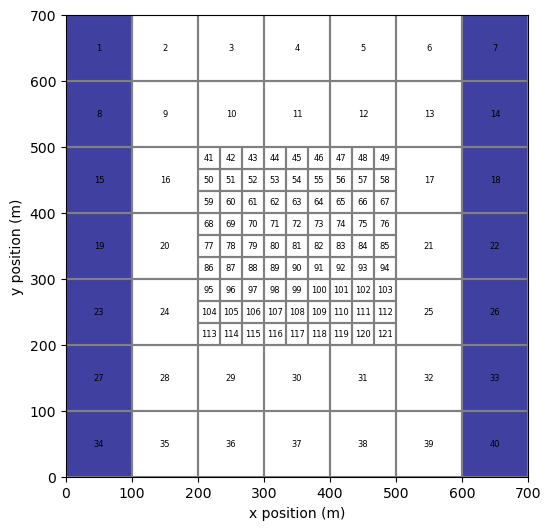

In [19]:
# Figure properties
figure_size = (6, 6)

fig = plt.figure(figsize=figure_size)
fig.tight_layout()

gwf = sim.get_model(model_name)

ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

# plot the grid
pmv.plot_grid()

# add the boundary conditions (CHD)
pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)

ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")

# this plots the cell ids
for i, (x, y) in enumerate(
    zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
):
    ax.text(
        x,
        y,
        f"{i + 1}",
        fontsize=6,
        horizontalalignment="center",
        verticalalignment="center",
    )

### Write the simulation to disk

In [31]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd-left...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 7 based on size of stress_period_data
    writing package chd-right...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 7 based on size of stress_period_data
    writing package oc...


### Run the simulation

In [32]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\AppData\Local\miniforge3\envs\mfandmore2024\Scripts\mf6.exe
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:08:14 with Intel(R) Fortran Intel(R) 64
  Compiler Classic for applications running on Intel(R) 64, Version 2021.11.1
                             Build 20231117_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released 

(True, [])

### Plot the results
Get the head data from the model.

In [33]:
gwf = sim.get_model(model_name)
head = gwf.output.head().get_data()[:, 0, :]

Get the specific discharge vector from the budget data object.

In [34]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
    gwf,
)

Create the figure.

Text(0.5, 1.0, 'Error (maximum = 0.014)')

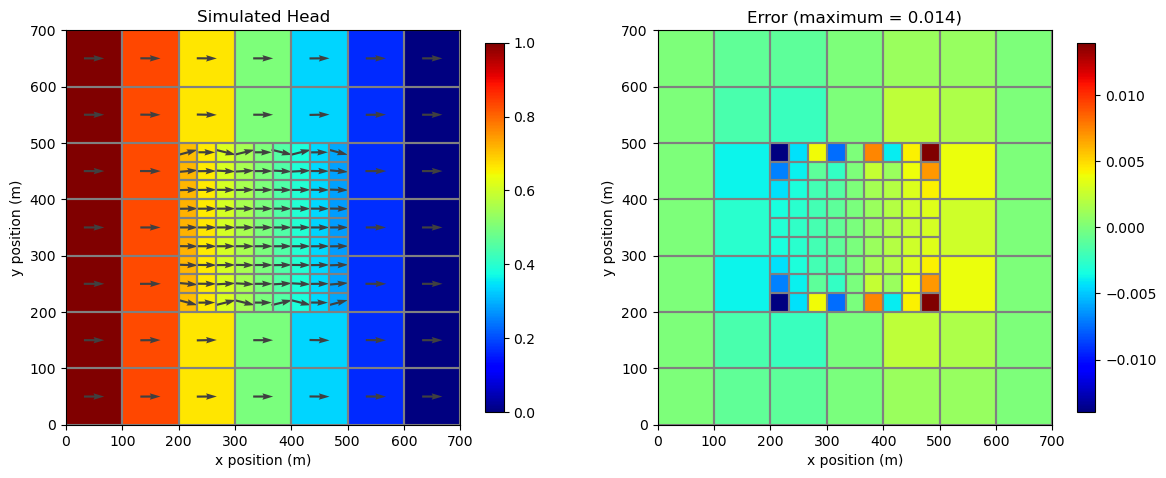

In [24]:
fig = plt.figure(figsize=(14, 8))
fig.tight_layout()

ax = fig.add_subplot(1, 2, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pmv.plot_grid()
cb = pmv.plot_array(head, cmap="jet")
pmv.plot_vector(
    qx,
    qy,
    normalize=False,
    color="0.25",
)
cbar = plt.colorbar(cb, shrink=0.6)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.set_title("Simulated Head")

ax = fig.add_subplot(1, 2, 2, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
pmv.plot_grid()
x = np.array(gwf.modelgrid.xcellcenters) - 50.0
slp = (1.0 - 0.0) / (50.0 - 650.0)
heada = slp * x + 1.0
cb = pmv.plot_array(head - heada, cmap="jet")
cbar = plt.colorbar(cb, shrink=0.6)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
max_error = np.amax(head-heada)
ax.set_title(f"Error (maximum = {max_error:.2g})")



### Interpret Results
**The exact solution to this problem is a uniform head gradient and uniform flow in the x direction**. 

On the left, specific discharge is plotted as arrows on top of the simulated head. 

The error in the simulated heads relative to the exact solution is plotted on the right. If the flow formulation is accurate, the error should be no greater than solver convergence tolerance `hclose`.